# A crash-course in Bayesian statistics

Bayes' theorem in often used in science to describe the probability density of a model parameter given some observational data:

\begin{equation}
    p(\theta|x)=\frac{p(x|\theta)\,p(\theta)}{p(x)}.
\end{equation}

Here:

 - $p(\theta|x)$ is the <b>posterior probability density</b> of some parameter $\theta$ given some data $x$.
 - $p(x|\theta)$ is the <b>likelihood</b> of $x$ occuring, given $\theta$.
 - $p(\theta)$ is the <b>prior probability density</b> of $\theta$, i.e. what we think $\theta$ might be, or how we think the distribution of $\theta$ may behave.
 - $p(x)$ is somewhat confusingly called the <b>evidence</b>. It's essentially a normalisation constant so that
    
\begin{equation}
    \int\limits_{\theta_\mathrm{min}}^{\theta_\mathrm{max}}p(\theta|x)\,\mathrm{d}x\equiv 1\,.
\end{equation}

## Gaia parallaxes

We are going to apply Bayes' theorem to infer stellar distance. However, first we look at the parallaxes.

A star in the sky has a "true" parallax $\varpi$, relative to Earth's orbit, for which Gaia has measured a parallax $\varpi'$ with uncertainty $\sigma_\varpi$.

If we assume the the measurement uncertainties are Gaussian, and that <i>a priori</i> all values of $\varpi$ are equally likely ($P(\varpi)=C$), then

\begin{equation}
    p(\varpi|\varpi')=\frac{1}{\sqrt{2\pi}\sigma_\varpi}\,\exp\left(-\frac{(\varpi'-\varpi)^2}{2\sigma_\varpi^2} \right)
\end{equation}

This is a trivial example. We've simply stated best estimate of $\varpi$ is $\varpi'$, and the uncertainty is Gaussian with standard deviation $\sigma_\varpi$.

## Gaia distances

Things get more complicated when we try an estimate the distance $\rho=1/\varpi$. First, we substitute $\rho$ in the previous equation:

\begin{align}
    p(\rho|\varpi')&=p(1/\varpi|\varpi')\,\frac{\mathrm{d}\varpi}{\mathrm{d}\rho}\,\\
    &=\frac{1}{\rho^2\sqrt{2\pi}\sigma_\varpi}\,\exp\left(-\frac{(\varpi'-1/\rho)^2}{2\sigma_\varpi^2}\right)
\end{align}

In [1]:
#import modules
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# define rho likelihood
def rho_likelihood(rho,pi_prime,sigma_pi):
    
    """
    
    Function: return likelihood of measured parallax given rho
    
    Arguments:
    
        rho: float
            distance (pc)
            
        pi_prime: float
            measured parallax (arcsec)
            
        sigma_pi: float
            parallax uncertainty
            
    Result
    
        p: float
            likelihood
    
    """
    
    p=np.exp(-(pi_prime-1./rho)**2/(2*sigma_pi**2))/(rho**2*sigma_pi*np.sqrt(2*np.pi))
    
    return p

In [3]:
# define plot function
def plot_posterior(rho,likelihood,li_args,prior=None,pr_args=None):
    
    """
    
    Subroutine: plots posterior pdf
    
    Arguments:
    
        rho: float
            array of rho values
    
        likelihood: function
            likelihood function of data (li_args) given rho
            
        li_args: list
            list of arguments of likelihood function
            
        sigma_pi: float
            parallax uncertainty
            
        prior: function
            prior distribution of rho
            
        pr_args: list
            list of arguments for prior function
    
    """
    
    # set posterior values
    p=likelihood(rho,*li_args)
    
    # apply prior
    if prior is not None:
        p*=prior(rho,*pr_args)
        
    # normalise p
    p/=np.trapz(p,rho)
        
    # make plot
    fig,ax=plt.subplots(1,1)
    ax.plot(rho,p)
    ax.set_xlabel("rho [pc]")
    ax.set_ylabel("$p(rho|pi_prime) [pc^-1]")
    
    mean=(rho*p).sum()/p.sum()
    st_dev=np.sqrt((p*(rho-mean)**2).sum()/p.sum())
    
    print(mean,st_dev)

Let's say we have star in IC348 with a measured parallax $\varpi'=3.125\,\mathrm{mas}$ and uncertainty $\sigma_\varpi=0.1\mathrm{mas}$. The posterior $p(\rho|\varpi')$ will look roughly Gaussian:

420.96506351859676 43.4551714227799


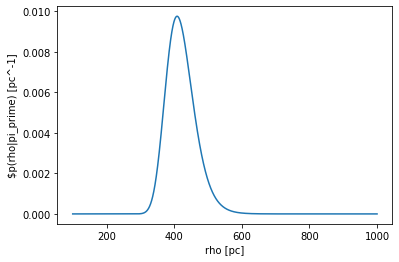

In [4]:
rho=np.linspace(100.,1000.,10000)
pi_prime=2.4e-3
sigma_pi=2.4e-4
plot_posterior(rho,rho_likelihood,[pi_prime,sigma_pi])

If we have a larger uncertainty -- say $\sigma_\varpi=1.0\mathrm{mas}$ -- the distribution has a heavy tail:

441.6523787570991 166.69123326337268


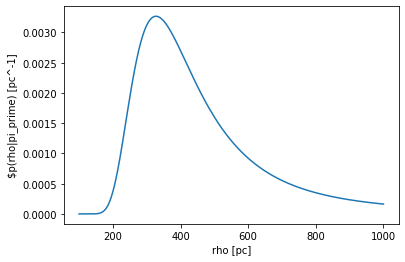

In [5]:
sigma_pi=1.e-3
plot_posterior(rho,rho_likelihood,[pi_prime,sigma_pi])

Things get a little less intuitive when we find a measured parallax which is negative. Here, there is still a well-defined posterior PDF, however, the function is pathological and does not have a defined mean or variance (or any statistical moments for that matter!).

710.9994192800916 170.91743731367845


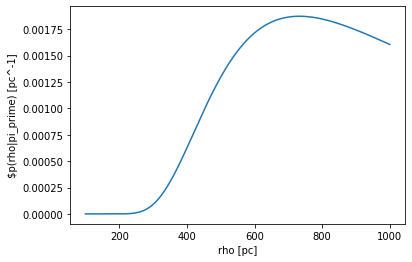

In [6]:
pi_prime=-1.e-4
plot_posterior(rho,rho_likelihood,[pi_prime,sigma_pi])

This pathological behaviour is not necessarily the nightmare it first appears. We can solve the problem using a well defined prior probability density distribution. Let's say that we <i>reckon</i> that our source is in a cluster 315 pc away, and we <i>reckon</i> that cluster has a radius of order 10 pc. We can use this to define a Gaussian prior PDF for $\rho$:

In [7]:
def rho_prior(rho,mu_rho,sigma_rho):
    
    """
    
    Function: return prior probaility density of rho
    
    Arguments:
    
        rho: float
            array of rho values
            
        mu_rho: float
            mean value of rho
            
        sigma_rho: float
            standard deviation of rho
            
    Result:
    
        p: float
            prior distribution of rho
    
    """
    
    p=np.exp(-(rho-mu_rho)**2/(2*sigma_rho**2))/(sigma_rho*np.sqrt(2*np.pi))
    
    return p

Now we can compute the posterior PDF of a target with a negative $\varpi'$:

317.6085008087124 9.860946606202967


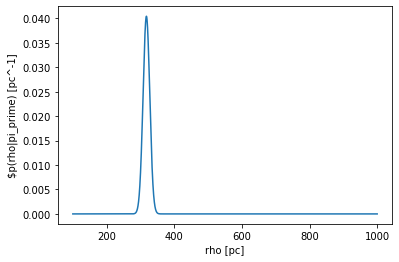

In [8]:
mu_rho=315.
sigma_rho=10.
plot_posterior(rho,rho_likelihood,[pi_prime,sigma_pi],rho_prior,[mu_rho,sigma_rho])

Now we have a<i>well behaved</i> posterior PDF, albeit one which is dominated by the prior PDF. In this case, the data doesn't tell us anything new, but it doesn't <i>break</i> our analysis either. 

## Pseudo-random number generation from an arbitrary PDF

Let's say that we want to randomly sample numbers from the above PDF (or indeed any strictly non-negative function). This can be performed by noting that:
\begin{equation}
    \frac{\int\limits_{x_\mathrm{min}}^{X}f(x)\,\mathrm{d}x}{\int\limits_{x_\mathrm{min}}^{x_\mathrm{max}}f(x)\,\mathrm{d}x}=\mathcal{R};\quad x_\mathrm{min}\leq X\leq x_\mathrm{max},
\end{equation}
where $X$ is a random variate from $f(x)$ and $\mathcal{R}$ is a random variate from the uniform distribution in the interval $[0,1]$. This can be difficult to invert analytically if $f(x)$ is complicated, but it is easy to compute numerically for most functions:

In [9]:
def cum_dist(f_x,x):
    
    """
    
        Function: numerically compute the cumulative distribution of g_x
        
        Arguments:
            f_x: float
                sampled f(x) values
                
            x: float
                x sampling points
    
        Result:
            F_x: float
                cumulative distribution of f(x)
                note: F_x[0] is by definition zero, and F_x[-1] is the 
                integral of f_x over the range defined by x
                
    """
    
    # initialise F_x
    F_x=np.zeros(f_x.shape,dtype=np.float)
    
    # compute trapezoidal cumulative distribution 
    F_x[1:]=np.cumsum(0.5*(f_x[1:]+f_x[:-1])*(x[1:]-x[:-1]))
    
    return F_x

def pdf_random(f_x,x,n):

    """
    
    Function: returns random numbers drawn from f_x
    
    Arguments:
            f_x: float
                sampled f(x) values
                
            x: float
                x sampling points
                
            n: int
                number of random numbers to return
    
        Result:
        
            X: float
                array of random numbers
    
    """
    
    # get F_x
    F_x=cum_dist(f_x,x)
    
    # normalise F_x
    F_x/=F_x[-1]
    
    # get array of uniform random numbers
    R=np.random.random(n)
    
    # invert (by linear interpolation) F_x to get X
    X=np.interp(R,F_x,x)
    
    return X

In [10]:
f_rho=rho_likelihood(rho,pi_prime,sigma_pi)*rho_prior(rho,mu_rho,sigma_rho)
Rho=pdf_random(f_rho,rho,100000)

print(Rho)
print(Rho.mean(),Rho.std())

# note that these values are approximately equal to those generated directly from the distribution!

[311.95120563 296.97624144 311.15725319 ... 313.17222942 326.99274922
 311.16694953]
317.5739489105802 9.814192134077262
